In [1]:
from quchem.Hamiltonian_Generator_Functions import *
from quchem.Graph import *
### HAMILTONIAN start
Molecule = 'H2'#'LiH'
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]#[('Li', (0., 0., 0.)), ('H', (0., 0., 1.45))]
num_shots = 10000
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='JW')
### HAMILTONIAN end

#####################################

Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(QubitHamiltonian)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anit_commuting_set = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)
anit_commuting_set

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 1800.03it/s]


{0: [(0.16592785032250768+0j) [Z0 Z3]],
 1: [(0.1686889816869329+0j) [Z0 Z1]],
 2: [(0.16592785032250768+0j) [Z1 Z2]],
 3: [(0.12062523481381837+0j) [Z1 Z3]],
 4: [(0.12062523481381837+0j) [Z0 Z2]],
 5: [(-0.09706626861762624+0j) []],
 6: [(0.174412876106516+0j) [Z2 Z3]],
 7: [(-0.2234315367466397+0j) [Z3], (0.04530261550868928+0j) [Y0 X1 X2 Y3]],
 8: [(0.171412826394024+0j) [Z1], (0.04530261550868928+0j) [X0 Y1 Y2 X3]],
 9: [(-0.04530261550868928+0j) [Y0 Y1 X2 X3], (0.17141282639402405+0j) [Z0]],
 10: [(-0.2234315367466397+0j) [Z2], (-0.04530261550868928+0j) [X0 X1 Y2 Y3]]}

The Hamiltonian is a sum of PauliWords:

$$H=\sum_{j=1}^{m} \alpha_{j} P_{j}$$

In this there are completely anti-commuting sets, denoted as $H_{S}$:

$$H_{S}=\sum_{P_{j} \in S} \alpha_{j} P_{j}$$

where:
- $\left\{P_{j}, P_{k}\right\}=0$ for $\forall P_{j} \neq P_{k} \in S$

We want **want** the sum of the sqaures of the cofactors to be 1:

$$H_{S}=\sum_{P_{j} \in S} \alpha_{j} P_{j}=\gamma_{l} \sum_{P_{j} \in S} \beta_{j} P_{j}$$

- aka: $\sum_{j} \alpha_{j}^{2}=1$
- and $\gamma_{l}$ is the correction factor

SO overall we can turn our Hamiltonian into $l$ anti_commutings sets as:

$$H=\sum_{j=1}^{m} \alpha_{j} P_{j}=\sum_{l=1}^{m_{c}} \gamma_{l} H_{S_{l}}$$

In [2]:
from openfermion.ops import QubitOperator

def Get_beta_j_cofactors(qubitOp_list):
    """
    Function takes in list of anti-commuting PauliWord tuples (PauliWord, constant)
    and returns the corresponding anti-commuting sets, but with new coefcators that
    obey eq (10) in ArXiv:1908.08067 (sum_j B_j^2 = 1) and an overall correction (gamma_l).

    Args:
        anti_commuting_set (list): A list of Pauliwords, where each entry is a tuple of (PauliWord, constant)

    Returns:
        dict: A dictionary of normalised_anti_commuting_set (key = 'PauliWords') and correction factor (key = 'gamma_l')

    .. code-block:: python
       :emphasize-lines: 4

       from quchem.Unitary_partitioning import *
       Anti_commuting_set = [('I0 Z1 I2 I3', (0.1371657293179602+0j)), ('Y0 Y1 X2 X3', (-0.04919764587885283+0j))]

       Get_beta_j_cofactors(Anti_commuting_set)
       >> {'PauliWords': [  ('I0 Z1 I2 I3', (0.9412848366792171+0j)),
                            ('Y0 Y1 X2 X3', (-0.33761347164735517+0j))
                          ],
          'gamma_l': (0.14572180914107857+0j)}

    """
    factor = sum([const**2 for qubitOp in qubitOp_list for PauliStrs, const in qubitOp.terms.items()])
    
    normalised_qubitOp_list=[QubitOperator(PauliStrs, const/np.sqrt(factor)) for qubitOp in qubitOp_list for PauliStrs, const in qubitOp.terms.items()]
    
    return {'PauliWords': normalised_qubitOp_list, 'gamma_l':factor}

In [151]:
Get_beta_j_cofactors(anit_commuting_set[10])

{'PauliWords': [(-0.9800573521796646+0j) [Z2],
  (-0.1987148369865346+0j) [X0 X1 Y2 Y3]],
 'gamma_l': (0.051973978584893145+0j)}

we can define an operator:

$$\mathcal{X}_{s k}=i P_{s} P_{k}$$

In [36]:
def Get_X_sk(qubitOp_Ps, qubitOp_Pk):
    """

    Converts P_s, P_k tuple into the corresponding X_sk term (PauliWord, correction_factor).
    Where X_sk = i P_s P_k [note that beta cofactors omitted in definition. When multiplying the PauliWords,
    they gain different cofactors, YX = -1i Z . This effect is taken into account by this function and the overall
    effect is returned as the correction factor.

    Args:
        X_sk (tuple): A tuple of (Pauliword_s, Pauliword_k) where each is a tuple of (PauliWord, constant)

    Returns:
        tuple: i* (P_s P_k) as a (Pauliword, constant). Note that constant here is NOT cofactor from Hamiltonian
               but in fact the correction term from multiplying all the Paulis. e.g. YX = -1i Z.

    .. code-block:: python
       :emphasize-lines: 7

       from quchem.Unitary_partitioning import *
       X_sk = (
              ('Z0 I1 I2 I3', (0.8918294488900189+0j)), # P_s
              ('Y0 X1 X2 Y3', (0.3198751585326103+0j))  # P_k
            )

       convert_X_sk(X_sk)
       >> ('X0 X1 X2 Y3', (1+0j))

    """
    convert_term ={
        'II': (1,'I'),
        'IX': (1,'X'),
        'IY': (1,'Y'),
        'IZ': (1,'Z'),

        'XI': (1,'X'),
        'XX': (1,'I'),
        'XY': (1j,'Z'),
        'XZ': (-1j,'Y'),

        'YI': (1,'Y'),
        'YX': (-1j,'Z'),
        'YY': (1,'I'),
        'YZ': (1j,'X'),

        'ZI': (1,'Z'),
        'ZX': (1j,'Y'),
        'ZY': (-1j,'X'),
        'ZZ': (1,'I')
    }
    
    
    PauliStr_tuples_Ps = [tup for PauliStrs, const in qubitOp_Ps.terms.items() for tup in PauliStrs]
    qubitNo_Ps, PauliStr_Ps = zip(*PauliStr_tuples_Ps)
    qubitNo_Ps = np.array(qubitNo_Ps)
    
    

    PauliStr_tuples_Pk = [tup for PauliStrs, const in qubitOp_Pk.terms.items() for tup in PauliStrs]
    qubitNo_Pk, PauliStr_Pk = zip(*PauliStr_tuples_Pk)
    qubitNo_Pk = np.array(qubitNo_Pk)
    
    common_qubits = np.intersect1d(qubitNo_Ps, qubitNo_Pk)
    
    PauliStr_Ps_common = np.take(PauliStr_Ps, np.where(np.isin(qubitNo_Ps, common_qubits) == True)).flatten()
    PauliStr_Pk_common = np.take(PauliStr_Pk, np.where(np.isin(qubitNo_Pk, common_qubits) == True)).flatten()
        
    new_paulistr_list=[]
    new_factor =[]
    for index, pauli_str_Ps in enumerate(PauliStr_Ps_common):
        
        pauli_str_Pk = PauliStr_Pk_common[index]
        qubitNo = common_qubits[index]
        
        combined_pauli_str = pauli_str_Ps+pauli_str_Pk
        
        if convert_term[combined_pauli_str][1] != 'I':
            new_pauli_str = convert_term[combined_pauli_str][1] + str(qubitNo)
            new_paulistr_list.append(new_pauli_str)

            new_factor.append(convert_term[combined_pauli_str][0])
       
    new_constant = np.prod(new_factor)
    
    for index, qubitNo in enumerate(qubitNo_Ps):
        if qubitNo not in common_qubits:
            Paulistring_Ps = PauliStr_Ps[index]
            new_paulistr_list.append(Paulistring_Ps+str(qubitNo))
    

    for index, qubitNo in enumerate(qubitNo_Pk):
        if qubitNo not in common_qubits:
            Paulistring_Pk = PauliStr_Pk[index]
            new_paulistr_list.append(Paulistring_Pk+str(qubitNo))
    
    seperator=' '
    pauliStr_list = seperator.join(new_paulistr_list)
    
    
    X_sk = QubitOperator(pauliStr_list, 1j*new_constant)
            
    return X_sk

In [5]:
aa = QubitOperator('Y0 X1 X2 X3', 0.75)
bb = QubitOperator('Y0 Z1 Y3',0.75)

Get_X_sk(aa, bb)

1j [Y1 X2 Z3]

In [6]:
list( aa.terms.values())

[0.75]

In [152]:
def Get_X_sk_operators(normalised_anticommuting_set_DICT, S=0): #
    """

    Function takes in a normalised_anti_commuting_set, which is a list of PauliWord tuples (PauliWord, constant),
    and returns each R_sk operator according to eq (11) in ArXiv:1908.08067.

    Args:
        normalised_anticommuting_set_DICT (list): A list of Pauliwords, where each entry is a tuple of (PauliWord, constant)
        S (optional, int) = index for PauliWord_S term. If not stated then takes first entry (index = 0)

    Returns:
        dict: A dictionary of 'PauliWord_S' yields (PauliWord, correction_factor_due_matrix_multiplication), t
        he normalisation correction value 'gamma_l' (complex) and each 'X_sk_theta_sk'... which is a list of
        dictionaries that are defined with 'X_sk' = (PauliWord, correction_factor_due_matrix_multiplication) and
        'theta_sk' is rotational angle in radians. NOTE: each element of X_sk_theta_sk dict is a list of sub
        dictionaries each associated to one sk term.

    .. code-block:: python
       :emphasize-lines: 9

       from quchem.Unitary_partitioning import *
       normalised_anticommuting_set_DICT = {
                                            'PauliWords': [   ('Z0 I1 I2 I3', (0.8918294488900189+0j)),
                                                              ('Y0 X1 X2 Y3', (0.3198751585326103+0j)),
                                                              ('X0 I1 I2 I3', (0.3198751585326103+0j))   ],
                                            'gamma_l': (0.1538026463340925+0j)
                                            }

       Get_X_sk_operators(normalised_anticommuting_set_DICT, S=0)
        >> {
             'X_sk_theta_sk': [   {'X_sk': ('X0 X1 X2 Y3', (1+0j)), 'theta_sk': (0.34438034648829496+0j)},
                                    {'X_sk': ('Y0 I1 I2 I3', (-1+0j)), 'theta_sk': (0.325597719954341+0j)}
                                ],
             'PauliWord_S': ('Z0 I1 I2 I3', (1+0j)),
             'gamma_l': (0.1538026463340925+0j)
           }

    """

    qubit_Op_list_normalisted = normalised_anticommuting_set_DICT['PauliWords']

    if len(qubit_Op_list_normalisted) > 1:

        k_indexes = [index for index in range(len(qubit_Op_list_normalisted)) if
                   index != S]

        Op_list = []
        beta_S = list(qubit_Op_list_normalisted[S].terms.values())[0]

        for k in k_indexes:
            X_sk_op =Get_X_sk(qubit_Op_list_normalisted[S], qubit_Op_list_normalisted[k])

            beta_K = list(qubit_Op_list_normalisted[k].terms.values())[0]

            tan_theta_sk = beta_K / beta_S
            theta_sk = np.arctan(tan_theta_sk)
            Op_list.append({'X_sk': X_sk_op,
                            'theta_sk_over2': theta_sk/2})  # , 'factor': normalised_anti_commuting_sets[key]['factor']})

            beta_S = beta_K*np.sin(theta_sk) + beta_S*np.cos(theta_sk)
        
        if beta_S<0:
            sign_gamma_l = -1
        else:
            sign_gamma_l = 1
#         return {'X_sk_theta_sk': Op_list, 'PauliWord_S': qubit_Op_list_normalisted[S],'gamma_l': normalised_anticommuting_set_DICT['gamma_l']}
        return {'X_sk_and_theta_terms': Op_list, 'PauliWord_S': QubitOperator(list(qubit_Op_list_normalisted[S].terms.keys())[0],1),
                'gamma_l': normalised_anticommuting_set_DICT['gamma_l']*sign_gamma_l}



In [178]:
diction = Get_beta_j_cofactors(anit_commuting_set[9])
Get_X_sk_operators(diction, S=1)

## PROBLEM ^^ the .terms.items() <-- seems to gumble pauliwords and so indexing of S becomes a problem!

{'X_sk_and_theta_terms': [{'X_sk': (1+0j) [X0 Y1 X2 X3],
   'theta_sk_over2': (-0.12919088186540034+0j)}],
 'PauliWord_S': 1 [Z0],
 'gamma_l': (0.03143468402431596+0j)}

$$U=e^{-i \theta Z_{0} Z_{1} Z_{2} Z_{3}} ==> R_z(2\theta)$$

SO:

$$R_{s k}=\exp \left(-i \frac{\theta_{s k}}{2} \mathcal{X}_{s k}\right) == R_z(\theta_{s k})$$

In [199]:
from quchem.quantum_circuit_functions import full_exponentiated_PauliWord_circuit
from openfermion.ops import QubitOperator

def Build_reduction_circuit(normalised_anticommuting_set_X_sk_DICT):

    for term in normalised_anticommuting_set_X_sk_DICT['X_sk_and_theta_terms']:
        
        pauliword_X_sk=list(term['X_sk'].terms.keys())[0]
        const_X_sk=list(term['X_sk'].terms.values())[0]
        
        theta_sk = term['theta_sk_over2'] *2
        
        full_exp_circ_obj = full_exponentiated_PauliWord_circuit(QubitOperator(pauliword_X_sk, -0.5j), theta_sk*const_X_sk)
        
        circuit = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
        
        yield circuit

X_sk_dict = {'X_sk_and_theta_terms': [{'X_sk': QubitOperator('X0 X1 Y2 X3', 1),
   'theta_sk_over2': np.pi/2}, {'X_sk': QubitOperator('Z1 X2 Y3', -1),
   'theta_sk_over2': np.pi/3}],
 'PauliWord_S': QubitOperator('X0 Y1 Y2 X3', 1),
 'gamma_l': (0.03143468402431594+0j)}
pp = Build_reduction_circuit(X_sk_dict)
print(cirq.Circuit(pp))


0: ────────────────────────────────────────────────────────H──────────@───────────────────────────@───────────H───
                                                                      │                           │
1: ──────────────@─────────────────────────@───────────────H──────────X───@───────────────────@───X───────────H───
                 │                         │                              │                   │
2: ───H──────────X───@─────────────────@───X───────────H───Rx(0.5π)───────X───@───────────@───X───Rx(-0.5π)───────
                     │                 │                                      │           │
3: ───Rx(0.5π)───────X───Rz(-0.667π)───X───Rx(-0.5π)───────H──────────────────X───Rz(π)───X───H───────────────────


$$R_{S} H_{S} R_{S}^{\dagger}=P_{s}$$

aka we want: $$H_{S}=  R_{S}^{\dagger} P_{s} R_{S}$$

to get this via a quantum circuit we do $P_{s}R_{S}$... THEN measure:

$$M_{z} U_{s} R_{S} |\psi_{UCCSD}\rangle == \langle \psi_{UCCSD}|R_{S}^{\dagger} P_{s} R_{S}|\psi_{UCCSD}\rangle$$ 

- $U_{s}$ is change of basis to measure  $P_{s}$ in comp basis!
- $M_{z}$ is measurement in Z



In [200]:
def Generate_Full_Q_Circuit_unitary_part(Full_Ansatz_Q_Circuit, normalised_anticommuting_set_X_sk_DICT):
    """
     TODO

    Args:
        

    Returns:
        full_circuit (cirq.circuits.circuit.Circuit): Full cirq VQE circuit

    """
    
    Reduction_circuit_obj = Build_reduction_circuit(normalised_anticommuting_set_X_sk_DICT)
    Reduction_circuit_circ = cirq.Circuit(Reduction_circuit_obj)
    

    measure_PauliS_in_Z_basis_obj = change_pauliword_to_Z_basis_then_measure(normalised_anticommuting_set_X_sk_DICT['PauliWord_S'])
    measure_PauliS_in_Z_basis_Q_circ = cirq.Circuit(cirq.decompose_once(
        (measure_PauliS_in_Z_basis_obj(*cirq.LineQubit.range(measure_PauliS_in_Z_basis_obj.num_qubits())))))
    
    full_circuit = cirq.Circuit(
       [
           Full_Ansatz_Q_Circuit.all_operations(),
           *Reduction_circuit_circ.all_operations(),
           *measure_PauliS_in_Z_basis_Q_circ.all_operations(),
       ]
    )
    return full_circuit

In [201]:
# ANSATZ CIRCUIT
from quchem.Ansatz_Generator_Functions import *
ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)

Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops, theta_parameters_ia, theta_parameters_ijab = ansatz_obj.Get_ia_and_ijab_terms()

Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops,
                                                                                                                    transformation='JW')

full_ansatz_Q_Circ = Ansatz_Circuit(Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab,
             Hamilt.molecule.n_qubits, Hamilt.molecule.n_electrons)

ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)

In [202]:
diction = Get_beta_j_cofactors(anit_commuting_set[8])
X_sk_dict = Get_X_sk_operators(diction, S=1)

Generate_Full_Q_Circuit_unitary_part(ansatz_cirq_circuit,X_sk_dict)

0: ───X───Rx(0.5π)───@───────────────────────@───Rx(-0.5π)───H───@──────────────────────@───────────H──────────H─────────────────────────────────────────────────────────────────────────────────────────────@───────────────────────────────@───────────H──────────Rx(0.5π)───@──────────────────────────────@───────────Rx(-0.5π)───Rx(0.5π)───@──────────────────────────────@───Rx(-0.5π)───H──────────@──────────────────────────────@──────────H───────────Rx(0.5π)───@───────────────────────────────────────@───────────Rx(-0.5π)───H──────────@───────────────────────────────────────@───────────H───────────H───@───────────────────────────────────────@──────────H───Rx(0.5π)───@──────────────────────────────────────@───Rx(-0.5π)───H───@────────────────────────────────────────────────────@───────────H──────────Ry(-0.5π)───M───
                     │                       │                   │                      │                                                                                                                    │                               │                                 │                              │                                  │                              │                          │                              │                                 │                                       │                                  │                                       │                           │                                       │                         │                                      │                   │                                                    │                                  │
1: ───X──────────────X───@───────────────@───X───────────────────X───@──────────────@───X───────────Rx(0.5π)───@───────────────────────@───Rx(-0.5π)───H───@──────────────────────@───────────H──────────H───X───@───────────────────────@───X───────────H──────────Rx(0.5π)───X───@──────────────────────@───X───────────Rx(-0.5π)───H──────────X───@──────────────────────@───X───H───────────Rx(0.5π)───X───@──────────────────────@───X──────────Rx(-0.5π)───H──────────X───@───────────────────────@───────────X───────────H───────────Rx(0.5π)───X───@───────────────────────@───────────X───────────Rx(-0.5π)───H───X───@───────────────────────@───────────X──────────H───Rx(0.5π)───X───@──────────────────────@───────────X───Rx(-0.5π)───H───X───@────────────────────────────────────────────@───X───────────H──────────Rx(0.5π)────M───
                         │               │                           │              │                          │                       │                   │                      │                              │                       │                                         │                      │                                          │                      │                                  │                      │                                         │                       │                                                  │                       │                                           │                       │                                         │                      │                                   │                                            │                                      │
2: ───H──────────────────X───Rz(-0.0π)───X───H───Rx(0.5π)────────────X───Rz(0.0π)───X───Rx(-0.5π)──────────────X───@───────────────@───X───────────────────X───@──────────────@───X───────────Rx(0.5π)───────────X───@───────────────@───X───Rx(-0.5π)───Rx(0.5π)──────────────────X───@──────────────@───X───Rx(-0.5π)───H──────────────────────────X───@──────────────@───X───H───H──────────────────────────X───@──────────────@───X───H──────────Rx(0.5π)───────────────────X───@───────────────@───X───────────Rx(-0.5π)───Rx(0.5π)───────────────────X───@───────────────@───X───────────Rx(-0.5π)───H───────────────────X───@───────────────@───X───────────H──────────H──────────────────X───@──────────────@───X───────────H───Rx(0.5π)──

In [203]:
from quchem.Simulating_Quantum_Circuit import *
class VQE_Experiment_UP():
    def __init__(self, graph_dict_sets, ansatz_circuit, n_shots, S_key_dict=None):
        self.graph_dict_sets = graph_dict_sets
        self.ansatz_circuit = ansatz_circuit
        self.S_key_dict = S_key_dict
        self.n_shots = n_shots

    def Calc_Energy(self):

        E_list=[]
        for set_key in self.graph_dict_sets:
            
            if len(self.graph_dict_sets[set_key])>1:

                normalised_set = Get_beta_j_cofactors(self.graph_dict_sets[set_key])

                if self.S_key_dict is None:
                    X_sk_dict = Get_X_sk_operators(normalised_set, S=0)
                else:
                    X_sk_dict = Get_X_sk_operators(normalised_set, S=self.S_key_dict[set_key])  
                
                Q_circuit = Generate_Full_Q_Circuit_unitary_part(ansatz_cirq_circuit,X_sk_dict)
                hist_key_str = Get_Histogram_key(X_sk_dict['PauliWord_S'])
                int_state_counter = Simulate_Quantum_Circuit(Q_circuit, self.n_shots, hist_key_str)
                binary_state_counter = Return_as_binary(int_state_counter, hist_key_str)
                exp_result = expectation_value_by_parity(binary_state_counter)
                E_list.append(exp_result*X_sk_dict['gamma_l'])

            else:
                qubitOp = self.graph_dict_sets[set_key][0]
                
                for PauliWord, const in qubitOp.terms.items():
                    if PauliWord is not ():
                        Q_circuit = Generate_Full_Q_Circuit(self.ansatz_circuit, qubitOp)
                        hist_key_str = Get_Histogram_key(qubitOp)
                        int_state_counter = Simulate_Quantum_Circuit(Q_circuit, self.n_shots, hist_key_str)
                        binary_state_counter = Return_as_binary(int_state_counter, hist_key_str)
                        exp_result = expectation_value_by_parity(binary_state_counter)
                        E_list.append(exp_result*const)
                    else:
                        E_list.append(const)
        return sum(E_list).real

    def Get_wavefunction_of_state(self, sig_figs=3):
        return Get_wavefunction(self.ansatz_circuit, sig_figs=sig_figs)


In [204]:
Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(QubitHamiltonian)
commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anit_commuting_set = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)


# ANSATZ CIRCUIT
from quchem.Ansatz_Generator_Functions import *
ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)
Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops, theta_parameters_ia, theta_parameters_ijab = ansatz_obj.Get_ia_and_ijab_terms()
Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops,transformation='JW')
full_ansatz_Q_Circ = Ansatz_Circuit(Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab,
             Hamilt.molecule.n_qubits, Hamilt.molecule.n_electrons)
ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)


n_shots=1000
experiment = VQE_Experiment_UP(anit_commuting_set, ansatz_cirq_circuit, n_shots, S_key_dict=None)
experiment.Calc_Energy()

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 519.35it/s]


-0.4900293170562965

0: Input_to_Funct: [0. 1. 2.]: Output: -0.4899446569093204
1: Input_to_Funct: [0. 1. 2.]: Output: -0.48971246724731954
2: Input_to_Funct: [0.   1.   2.05]: Output: -0.48943919899619753
3: Input_to_Funct: [0.   1.   2.05]: Output: -0.4900218081500951
4: Input_to_Funct: [0.   1.   2.05]: Output: -0.49019112844404733
5: Input_to_Funct: [0.   1.   2.05]: Output: -0.49017184063385366
6: Input_to_Funct: [-3.12500000e-05  1.00416667e+00  2.04583333e+00]: Output: -0.4900678926766839
7: Input_to_Funct: [-3.12500000e-05  1.00416667e+00  2.04583333e+00]: Output: -0.4899228661303929
8: Input_to_Funct: [-3.12500000e-05  1.00416667e+00  2.04583333e+00]: Output: -0.4887744326640576
9: Input_to_Funct: [-3.12500000e-05  1.00416667e+00  2.04583333e+00]: Output: -0.4892723816709791
10: Input_to_Funct: [-3.12500000e-05  1.00416667e+00  2.04583333e+00]: Output: -0.4903193701488784
11: Input_to_Funct: [-3.12500000e-05  1.00416667e+00  2.04583333e+00]: Output: -0.49085839774492096
12: Input_to_Funct: [-3.125

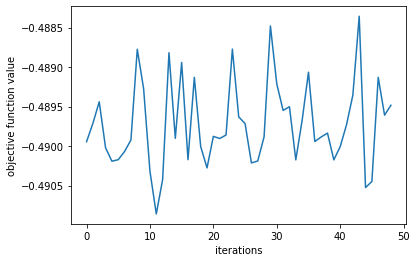

In [205]:
def GIVE_ENERGY(theta_ia_theta_jab_list):
    theta_ia = theta_ia_theta_jab_list[:len(theta_parameters_ia)]
    theta_ijab = theta_ia_theta_jab_list[len(theta_parameters_ia):]
    
    ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)

    VQE_exp_UP = VQE_Experiment_UP(anit_commuting_set, ansatz_cirq_circuit, n_shots, S_key_dict=None)
    
    return VQE_exp_UP.Calc_Energy()

### optimizer
from quchem.Scipy_Optimizer import *
# THETA_params = [*theta_parameters_ia, *theta_parameters_ijab]
THETA_params=[0,1,2]
GG = Optimizer(GIVE_ENERGY, THETA_params, 'Nelder-Mead', store_values=True, display_iter_steps=True,
               tol=1e-5,
               display_convergence_message=True)
GG.get_env(50)
GG.plot_convergence()
plt.show()

# REDUCED H2 ANSATZ

In [211]:
from quchem.Simulating_Quantum_Circuit import *
from quchem.Ansatz_Generator_Functions import *
from openfermion.ops import QubitOperator

def H2_ansatz(theta):
    HF_circ = [cirq.X.on(cirq.LineQubit(0)), cirq.X.on(cirq.LineQubit(1))]
    
    full_exp_circ_obj = full_exponentiated_PauliWord_circuit(QubitOperator('Y0 X1 X2 X3', -1j), theta)
    UCCSD_circ = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
    full_circuit = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations()])
    
    return full_circuit
    
H2_ansatz(np.pi)    

0: ───X───Rx(0.5π)───@──────────────────────────────@───Rx(-0.5π)───
                     │                              │
1: ───X───H──────────X───@──────────────────────@───X───H───────────
                         │                      │
2: ───H──────────────────X───@──────────────@───X───H───────────────
                             │              │
3: ───H──────────────────────X───Rz(2.0π)───X───H───────────────────

In [212]:
n_shots=1000

def GIVE_ENERGY(THETA):
    H2_ansatz_cirq_circuit = H2_ansatz(THETA)
    VQE_exp_UP = VQE_Experiment_UP(anit_commuting_set, H2_ansatz_cirq_circuit, n_shots, S_key_dict=None)
    
    return VQE_exp_UP.Calc_Energy()


-0.491030221007607


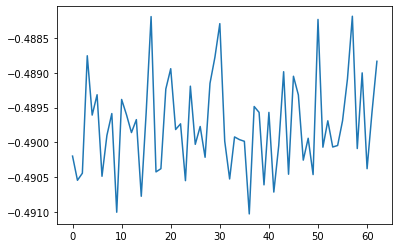

In [213]:
### full angle scan

import matplotlib.pyplot as plt
%matplotlib inline

theta_list = np.arange(0,2*np.pi, 0.1)

E_list = [GIVE_ENERGY(theta) for theta in theta_list]

plt.plot(E_list)
print(min(E_list))